### Title : Customer churn prediction

### Business Understanding
The objective of the project is to build a machine learning model that predicts customer churn.

### Project Description
Telecommunications sector is concerned with retaining customers due to the high costs associated with acquiring new ones. Customer churn, or turnover, occurs when customers cease their subscriptions or services. This can result in lost revenue and necessitate additional marketing expenditures to attract new clients.
To address this challenge, the project involves leveraging data analytics techniques and machine learning to analyze service usage patterns and predict customer churn


### Questions
 -Is there a relationship between Churn and monthly charges/ does increase in monthly charges leads to churn?
 
 -What is the Churn rate of senior citizen and non-senior citizen?

 -What is the total percentage/ number of those who churn?



### Hypothesis
H0: There is significant correlation between TotalCharges and customer churn

HA: There is no significant correlation between TotalCharges and customer churn

### Data Understanding



In [2]:
# importing  libraries
import pyodbc 
from dotenv import dotenv_values 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
warnings.filterwarnings('ignore')


In [3]:
# loading environment variables
environment_variables = dotenv_values('.env')
 
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
connection = pyodbc.connect(connection_string)

### Loadind Data

In [6]:
# Loading dataset 1 for training & evaluation
query = "select * from dbo.LP2_Telco_churn_first_3000" 

train_data1 = pd.read_sql(query, connection)




In [7]:
# converting database data  to csv file
train_data1.to_csv('train1.csv')

In [8]:
# loading dataset 2 for training & evaluation
train_data2 = pd.read_csv('./data_customer Churn/LP2_Telco-churn-second-2000.csv')

In [9]:
test_data = pd.read_excel('./data_customer Churn/Telco-churn-last-2000.xlsx')

### Reading Data

In [10]:
train_data1.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True


In [11]:
train_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [12]:
train_data2.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No


### EDA

In [13]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [14]:
test_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55


### Merging Data

In [250]:
# merging dataset
df = pd.concat([train_data1, train_data2])

In [16]:
df.to_csv('merged_data.csv')

In [252]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True


### Exploratory Data Analysis

In [253]:
# checking data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

### Cleaning Data

In [254]:
# change column title to lower case
df.columns=df.columns.str.lower()

In [255]:
df.drop('customerid', axis=1, inplace=True)


In [256]:
# Replace True, False with Yes & No
df.replace({True:'Yes', False: 'No'}, inplace=True)

In [257]:
# replacing string 
df['totalcharges']=df['totalcharges'].replace(" ", np.nan)

In [258]:
# changing datatype of TotalCharges Column to numeric
df['totalcharges']= pd.to_numeric(df['totalcharges'])

In [259]:
# checking for null values
df.isnull().sum()

gender                0
seniorcitizen         0
partner               0
dependents            0
tenure                0
phoneservice          0
multiplelines       269
internetservice       0
onlinesecurity      651
onlinebackup        651
deviceprotection    651
techsupport         651
streamingtv         651
streamingmovies     651
contract              0
paperlessbilling      0
paymentmethod         0
monthlycharges        0
totalcharges          8
churn                 1
dtype: int64

### Handling missing values

-It was observed that those without phone service automatically did not have multiple lines hence the missing values in that column
-No will therefore be used to fill the missing values

-Those without internet service also did not have onlinesecurity, onlinebackup, Device protection, streamingmovies, streamingTv, Techsupport
-No will therefore be used to fill the missing values

Total Charges is observed to be aa product of the tenure and monthly charge. The Assumption is that the missing values are those with less than a month tenure
Total charge for a month will be used to fill the missing values




In [260]:
 # Filling  missing values with 'no'
col_to_fill = ['multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
for items in col_to_fill:
    if df[items].isna().any() == True:
        df[items] = df[items].fillna('No')

In [261]:
#Creating a mask variable for the missing values in the column for totalcharges
mask = df['totalcharges'].isna()
 
# Filling the missing values of totalcharge with the values of the monthlycharge
df['totalcharges'].fillna(df.loc[mask,'monthlycharges'], inplace = True)
 

In [262]:
# Filling the missing value in the churn column with mode
mode_churn = df['churn'].mode()[0]
df['churn'] = df['churn'].fillna(mode_churn)
 

In [263]:
df.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [264]:
#Check duplicates
df.duplicated().sum()

10

In [265]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
monthlycharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
totalcharges,5043.0,2298.488381,2269.455293,18.799999,415.724997,1398.599976,3857.575073,8670.100000


### Observations
The features are not on the same scale as observed by TotalCharges column

There is an imbalance in the data

In [266]:
# create a list of numeric columns
numerics = []
for column in df.columns:
    if df[column].dtype != "O":
        numerics.append(column)
numerics

['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']

In [267]:
# create a list of categorical columns
categoricals = []
for column in df.columns:
    if df[column].dtype == "O":
        categoricals.append(column)
categoricals

['gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

### Univariant Analysis

array([[<Axes: title={'center': 'seniorcitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'monthlycharges'}>,
        <Axes: title={'center': 'totalcharges'}>]], dtype=object)

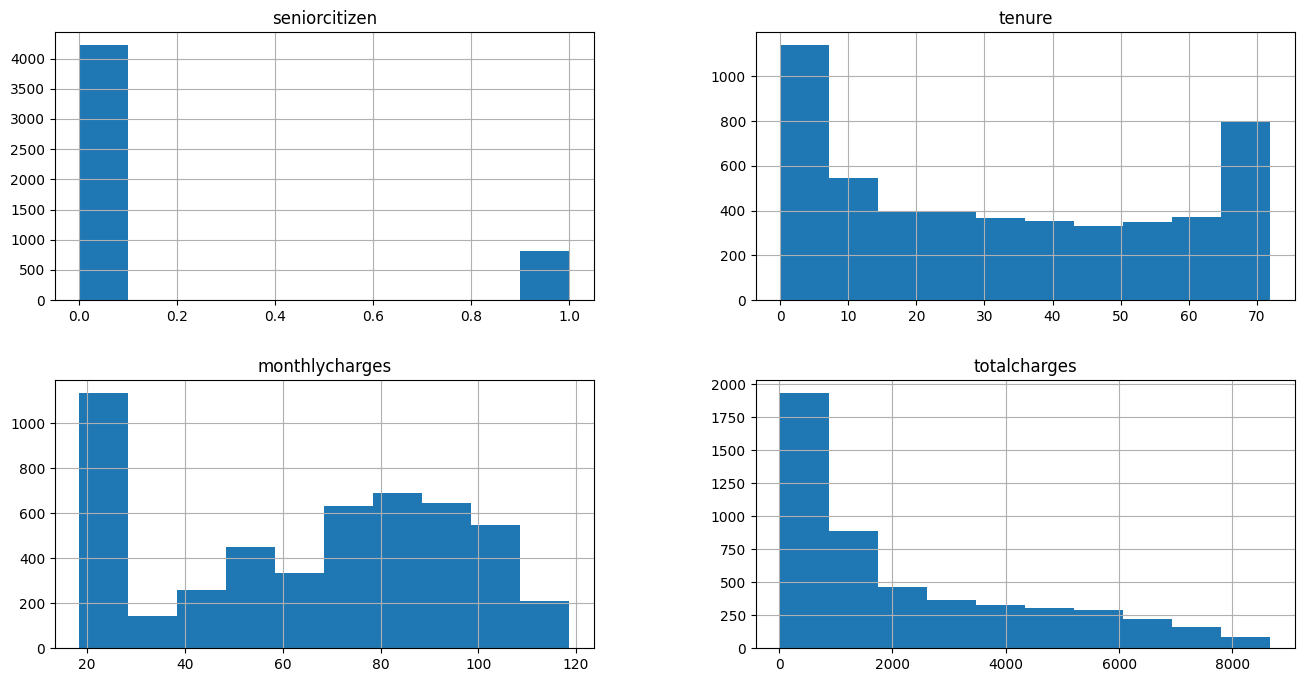

In [268]:
df.hist(figsize=(16,8))

### Bivariant Analysis

In [269]:
# visualizing distribution of categorical columns
figsize = (700, 500)

for column in categoricals:
    
    
    

     #Visualize the raw numbers of relative churn rates
    fig = px.histogram(df, x=df[column], text_auto=True, color=df["churn"],
                       
                       barnorm="percent", barmode="relative",
                       title=f"Distribution of values in the {column} column by Churn status")
                   
    fig.update_layout(width=figsize[0], height=figsize[1])
    
    fig.show()

    

In [276]:
fig = px.histogram(df, x=df['churn'], text_auto=True, color=df["churn"],

title=f"Number of customers who churn")  

fig.show()

### Multivariant Analysis

In [270]:
# Visualize relationships between variables
## Calculate the correlations
corr_matrix = df.corr(numeric_only=True)

## Visualize the correlations 
fig = px.imshow(corr_matrix, text_auto=True, width = 1080, height = 760,
                title= f"correlation matrix")
fig.show()

### Observations
From the correlation matrix above, tenure and total charges have a significant relationship due to the coeficient being close to 1

Again, monthly charge and total charges also have a significant relationship